In [1]:
import gymnasium as gym
import utils
from experiments import *

In [4]:
def mean_var_experiment(
    env, episodes, batch_size=256, hidden_dim=128, num_runs=1, GAMMA=0.99
) -> dict:
    state_dim: int = env.observation_space.shape[0]
    action_dim: int = env.action_space.n

    loss_functions = []
    action_selection_methods = []

    for beta in [-0.5, -0.25, 0, 0.25, 0.5]:
        action_selection_methods.append(
            (
                mean_logvar_actionselection(action_dim=action_dim, beta=beta),
                f"log_uncertainity_{beta}",
            )
        )

    action_selection_methods.append(
        (mean_logvar_maxexpected(action_dim=action_dim), "maxexpected")
    )

    loss_functions.append(
        (distributional_qn_loss(GAMMA=GAMMA, method="Dkl"), "dkl_loss")
    )
    loss_functions.append(
        (distributional_qn_loss(GAMMA=GAMMA, method="Wasserstein"), "wasserstein_loss")
    )
    experimental_results = {}

    configs = {
        "action_dim": action_dim,
        "state_dim": state_dim,
        "episodes": episodes,
        "gamma": GAMMA,
        "eps": 0.1,
        "tau_soft_update": 0.05,
        "update_steps": 1
    }
    for loss_function in loss_functions:
        for action_selection_method in action_selection_methods:
            name = f"{loss_function[1]}_{action_selection_method[1]}"
            results = []
            for exp_n in range(num_runs):
                print(name)
                online_network = MeanVarianceQNetwork(
                    state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim
                ).to(DEVICE)
                target_network = MeanVarianceQNetwork(
                    state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim
                ).to(DEVICE)
                hard_target_update(online_network, target_network)
                optimizers = optim.Adam(online_network.parameters(), lr=1e-3)
                replay_buffer = ReplayBuffer()
                try:
                    rewards = training_loop_qn(
                        env=env,
                        online_qnet=online_network,
                        target_qnet=target_network,
                        optimizers=optimizers,
                        td_lossfunc=loss_function[0],
                        select_action=action_selection_method[0],
                        replay_buffer=replay_buffer,
                        configs=configs,
                        print_info=False,
                        discrete=True,
                    )
                    results.append(rewards)
                except Exception as e:
                    print(e)
            experimental_results[name] = results
    return experimental_results


In [ ]:
env = gym.make("CartPole-v1")
results = mean_var_experiment(env, episodes = 500, batch_size = 64)

dkl_loss_log_uncertainity_-0.5


In [8]:
results

{'dkl_loss_log_uncertainity_-0.5': [[158.0,
   120.0,
   84.0,
   91.0,
   60.0,
   116.0,
   92.0,
   157.0,
   80.0,
   65.0,
   76.0,
   156.0,
   75.0,
   138.0,
   102.0,
   78.0,
   65.0,
   58.0,
   9.0,
   9.0,
   10.0,
   9.0,
   9.0,
   10.0,
   9.0,
   10.0,
   9.0,
   10.0,
   9.0,
   10.0,
   9.0,
   10.0,
   11.0,
   15.0,
   46.0,
   11.0,
   29.0,
   39.0,
   48.0,
   56.0,
   64.0,
   111.0,
   120.0,
   130.0,
   112.0,
   113.0,
   156.0,
   69.0,
   61.0,
   13.0,
   10.0,
   55.0,
   73.0,
   52.0,
   66.0,
   58.0,
   60.0,
   66.0,
   97.0,
   98.0,
   79.0,
   80.0,
   66.0,
   200.0,
   91.0,
   26.0,
   22.0,
   87.0,
   142.0,
   110.0,
   89.0,
   89.0,
   72.0,
   61.0,
   57.0,
   77.0,
   70.0,
   87.0,
   23.0,
   15.0,
   62.0,
   22.0,
   63.0,
   67.0,
   63.0,
   119.0,
   15.0,
   19.0,
   19.0,
   19.0,
   12.0,
   15.0,
   17.0,
   16.0,
   17.0,
   21.0,
   72.0,
   69.0,
   36.0,
   86.0,
   90.0,
   41.0,
   30.0,
   23.0,
   26.0,
   26.0,
   

In [6]:
gameres = utils.avg_results(results)

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


Plot saved as: GAME NAME_rewards_plot_20250417_173146.png


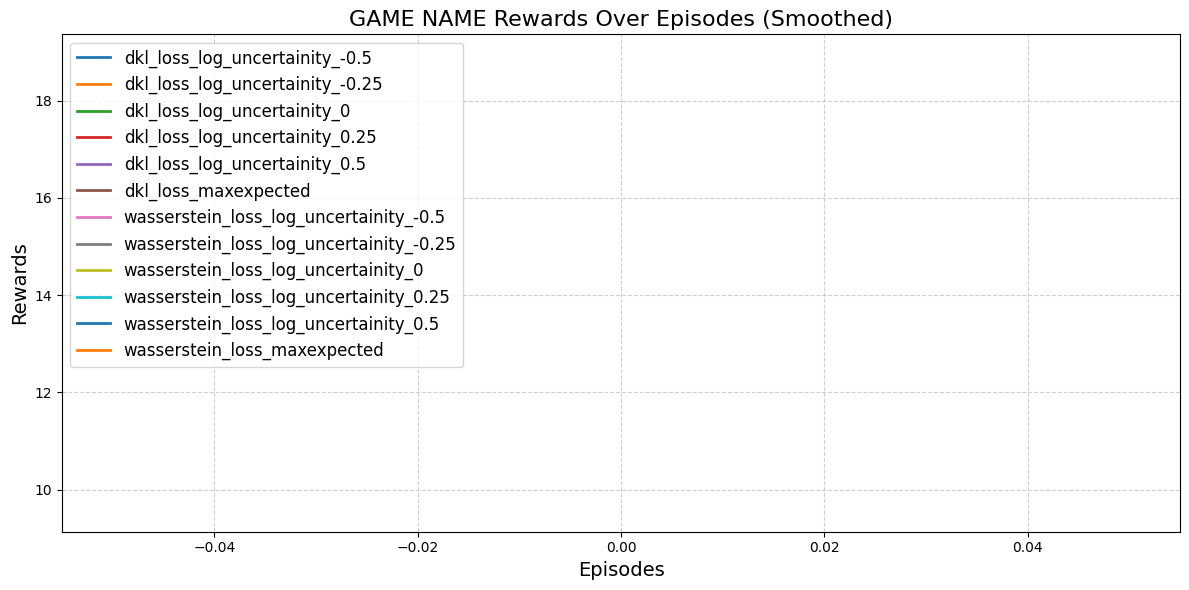

In [7]:
plot_improved_rewards(gameres)

In [15]:
utils.av

<module 'utils' from '/Users/potty/Desktop/projects/fyp/src/utils.py'>

In [8]:
[1,2,3][0:]

[1, 2, 3]